This notebook was used to test the new structure of our code.

In [2]:
from data_generation import *
from imputation import *
from visualization import *

%reload_ext autoreload
%autoreload 2

MCAR - Missing data percentage:  0.05
EM iterations completed:  5
MCAR - Missing data percentage:  0.1
EM iterations completed:  9
MCAR - Missing data percentage:  0.15
EM iterations completed:  11
MCAR - Missing data percentage:  0.2
EM iterations completed:  17
MCAR - Missing data percentage:  0.25
EM iterations completed:  19
MCAR - Missing data percentage:  0.3
EM iterations completed:  15
MCAR - Missing data percentage:  0.35
EM iterations completed:  29
MCAR - Missing data percentage:  0.4
EM iterations completed:  45
MCAR - Missing data percentage:  0.45
EM iterations completed:  34
MCAR - Missing data percentage:  0.5
EM iterations completed:  34
MCAR - Missing data percentage:  0.55
EM iterations completed:  70
MCAR - Missing data percentage:  0.6
EM iterations completed:  75
MCAR - Missing data percentage:  0.05
EM iterations completed:  9
MCAR - Missing data percentage:  0.1
EM iterations completed:  11
MCAR - Missing data percentage:  0.15
EM iterations completed:  12
MCAR 

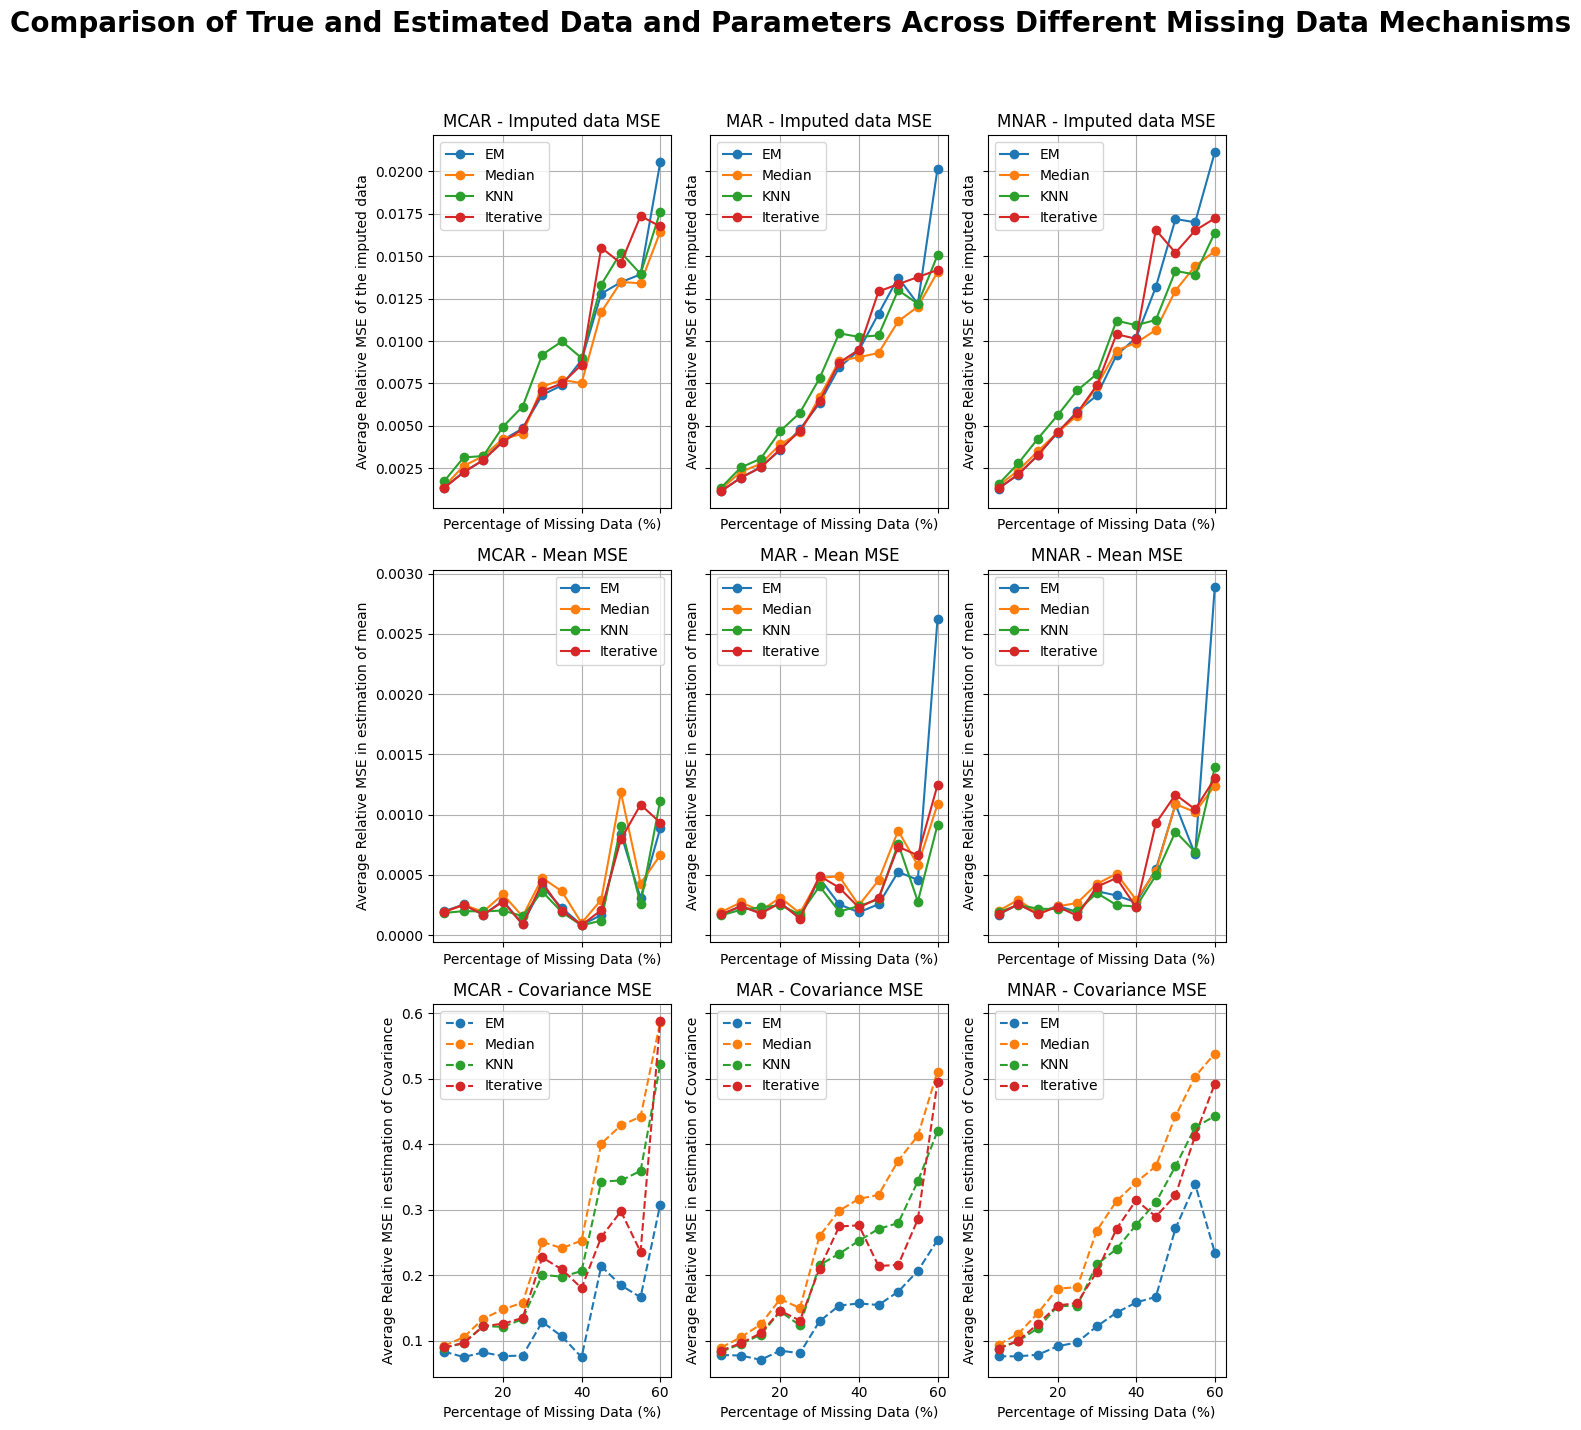

In [6]:
from numpy import real


data, mean, sigma = generate_synthetic_data(n_samples = 200, n_features = 10)
#print(data)
#plot_combined(data, em_iterations =2)
plot_all_differences_combined(data, real_mean = mean, real_cov = sigma, em_iterations = 5, verbose =True)
#print('mean' , mean)
#print('cov' , cov)
#data = generate_incomplete_data(data, miss_percentage = 0.3, mecha = 'MCAR', p_obs = 0.2, opt = 'logistic', q = 0.5)


In [64]:
from scipy.special import psi, gammaln #psi is the digamma function, gammaln is the log of the gamma function
#from scipy.optimize import newton
from scipy.optimize import brentq
from scipy.optimize import fsolve

def nu_step_em(nu_r, d, w, gamma_r):
    myphi = lambda x: psi(x) - np.log(x)

    A  = np.sum(w*(gamma_r - np.log(gamma_r) - 1))
    f = lambda x: myphi(x/2) - myphi((x+d)/2) + A
    
    # Brent's method to find the root of f (the deg of freedom)
    #a, b = 1.9, 15  # range in which we expect nu to be
    #nu_r_updated = brentq(f, a, b)
    #nu_r_updated = newton(func=f, x_0=nu_r) #if newton method is used

    #fsolve method to find the root of f (the deg of freedom)
    nu_r_updated = fsolve(func = f, x0 = nu_r)

    return nu_r_updated[0]


def studentT_step_em(X, w, mu_r, sigma_r, nu_r, regularize = 1e-4):
    n, d = X.shape

    delta_r = np.sum(((np.linalg.inv(sigma_r) @ (X - mu_r).T) * (X - mu_r).T).T, axis=1)

    #delta_r = np.dot((X[:,None] - mu_r).T, np.linalg.inv(sigma_r)) @ (X[:,None] - mu_r)
    gamma_r = (nu_r + d) / (nu_r + delta_r)

    mu_r_updated = np.sum(X * (w * gamma_r)[:, np.newaxis], axis=0) / np.sum(w * gamma_r)
    
    sigma_r_updated = np.zeros((d, d))

    for i in range(n):
        diff = X[i] - mu_r_updated
        sigma_r_updated += w[i] * gamma_r[i] * np.outer(diff, diff)

    sigma_r_updated /= np.sum(w * gamma_r)
    sigma_r_updated += regularize * np.eye(d) # to avoid singularities

    nu_r_updated = nu_step_em(nu_r, d, w, gamma_r)
    nu_r_updated = min(nu_r_updated, 1e5)

    return mu_r_updated, sigma_r_updated, nu_r_updated


In [39]:
import numpy as np
from scipy.special import gamma
import stat_utils

def log_likelihood_student(X, mean, sigma, nu):
    """
    Calculates the log-likelihood of the data X given the Student's t-distribution parameters nu, mean and sigma (the scale matrix).
    """
    n, d = X.shape
    log_likelihood = 0
    for i in range(n):
        mahalanobis = np.dot(np.dot((X[i] - mean).T, np.linalg.inv(sigma)), (X[i] - mean))
        log_likelihood += np.log(1 + mahalanobis / nu)
    log_likelihood = n*np.log(gamma((d+nu)/2)) - n*np.log(gamma(nu/2)) - 0.5*n*d*np.log(nu*np.pi) -0.5*n*np.log(np.linalg.det(sigma)) - 0.5*(d+nu)*log_likelihood
    return log_likelihood


def em_student_t(X, tol=1e-5, max_iter=100, initial_nu=1, weights=None):
    n, d = X.shape
    
    if weights is None:
        weights = np.ones(n)/n
    w=weights

    # Initial guesses
    mean = np.nanmean(X, axis=0) #empirical mean
    #observed = ~mask
    sigma = stat_utils.nan_covariance(X)
    nu = initial_nu

    iterations = 0
    old_log_likelihood = -np.inf
    log_likelihood_diff = 10 
    while iterations < max_iter and log_likelihood_diff > tol:
        iterations += 1
        #update paramenters
        mean, sigma, nu = studentT_step_em(X, w, mean, sigma, nu)

        # Check for convergence
        log_likelihood = log_likelihood_student(X, mean, sigma, nu)
        log_likelihood_diff = log_likelihood - old_log_likelihood
        print('log_likelihood_diff: ', log_likelihood_diff)
        old_log_likelihood = log_likelihood

    return mean, sigma, nu



In [54]:
# Generation of the multivariate t-distributed data
n = 100  # number of samples
d = 4  # number of features
df = 4  # degrees of freedom
mean = np.random.randn(d)  # mean vector
scale_matrix = 2*np.random.rand(d,d) - 2*np.random.rand(d,d) 
scale_matrix = scale_matrix.T.dot(scale_matrix) # make Scale matrix symmetric positive definite
real_cov = scale_matrix * df / (df - 2)  # real covariance matrix
#print(np.linalg.eigvals(scale_matrix))  # check eigenvalues

X = generate_student_t(df, mean = mean, scale_matrix = scale_matrix, n_samples = n)
X = produce_NA(X, 0.3)['X_incomp']
#transform X to np array
X = np.array(X)

print('real mean: ', mean)
print('real sigma: ', scale_matrix)
print('real nu: ', df)




real mean:  [-0.93304751 -0.64459525 -0.17872715  2.85628776]
real sigma:  [[ 3.20136369 -1.76750658  0.49033456 -0.53443513]
 [-1.76750658  6.15914044 -2.65100909 -2.17583055]
 [ 0.49033456 -2.65100909  1.63166765  0.92480779]
 [-0.53443513 -2.17583055  0.92480779  1.36962014]]
real nu:  4


In [67]:
mean, sigma, nu = em_student_t(X, tol=1e-4, max_iter=100, initial_nu=4, weights=None)
print('estimated mean: ', mean)
print('estimated sigma: ', sigma)
print('estimated nu: ', nu)

log_likelihood_diff:  nan
estimated mean:  [nan nan nan nan]
estimated sigma:  [[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
estimated nu:  4.0


: 

In [31]:
X =np.random.randn(10,3)
X[:,None]

array([[[ 0.09481726, -0.32526763, -0.06738278]],

       [[-0.04277118, -0.33537738, -0.78050394]],

       [[-0.87052795, -2.09524383,  1.87921669]],

       [[-0.24626001, -1.18902318, -1.05319172]],

       [[ 1.52024145, -0.50773495, -1.41193833]],

       [[-0.48240172, -0.55405537, -0.12969272]],

       [[-0.70776799, -1.90150203,  1.51544252]],

       [[ 0.19775014,  0.00266892,  1.39791218]],

       [[ 0.05465727,  1.54570281, -1.85370771]],

       [[-1.92209934,  0.23545146, -0.41520304]]])